## Data Acquisition and Cleanup

Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import scipy.stats as stats
import hvplot.pandas
import requests
import numpy as np
import json
import os
import csv
from api_keys import geoapify_key

Open and read the CSV Zillow File. Put the data into a pandas dataframe.

In [2]:
csvpath = os.path.join('Resources', 'zillowzipcodedata.csv')
with open(csvpath) as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    zillowdf = pd.DataFrame(csvreader)

Reduce to data for Phila, PA

In [3]:
# these are the timepoints 2017-2023 to match crime data
fullphillyzillow = zillowdf.loc[(zillowdf[6] == 'Philadelphia')&(zillowdf[5] == 'PA'),2:]
fullphillyzillow = fullphillyzillow.rename(columns={2:'zip_code'})
fullphillyzillow = fullphillyzillow.set_index('zip_code')
fullphillyzillow = fullphillyzillow.loc[:,np.arange(218,291,12)]

# this is the final timepoint
phillyzillow = zillowdf.loc[(zillowdf[6] == 'Philadelphia')&(zillowdf[5] == 'PA'),(2,290)]
phillyzillow = phillyzillow.rename(columns={2:'zip_code',290:'ZHVI'})
phillyzillow = phillyzillow.set_index('zip_code')

Access the Philly crime API; import only crime data that has a valid zip code field.

In [4]:
philly_crime_url = 'https://phl.carto.com/api/v2/sql?q=SELECT * FROM arrests_zipcode'
philly_crime = requests.get(philly_crime_url).json()
philly_crime = pd.DataFrame(philly_crime['rows'])

Access geoapify to convert zip codes to coordinates for map plot.

In [5]:
def zipcoding(df):
    df['lat'] = ''
    df['lon'] = ''

    for index, row in df.iterrows():
        zipcode = index
        zipcodeurl = f'https://api.geoapify.com/v1/geocode/search?text={zipcode}&lang=en&limit=10&type=postcode&filter=countrycode:us&apiKey={geoapify_key}'
        zipcodecoords = requests.get(zipcodeurl).json()
        try:
            lat = zipcodecoords['features'][0]['properties']['lat']
            lon = zipcodecoords['features'][0]['properties']['lon']
            df.loc[index,'lat'] = lat
            df.loc[index,'lon'] = lon
        except:
            print('Bad item')
            lat = ''
            lon = ''
            pass

Set color and size of each data point. Larger points have more crime. Redder points are zip codes with lower ZHVI scores; green are zip codes with better ZHVI scores.

In [6]:
def mapprops(df):
    for index,row in df.iterrows():
        df['size'] = df['offense_count']*2
        if (df.loc[index,'ZHVI'] < 70000.):
            df.loc[index,'color'] = '#790909'
        elif (df.loc[index,'ZHVI'] >= 70000.)&(df.loc[index,'ZHVI'] < 125000.):
            df.loc[index,'color'] = '#793e09'
        elif (df.loc[index,'ZHVI'] >= 125000.)&(df.loc[index,'ZHVI'] < 200000.):
            df.loc[index,'color'] = '#795d09'
        elif (df.loc[index,'ZHVI'] >= 200000.)&(df.loc[index,'ZHVI'] < 300000.):
            df.loc[index,'color'] = '#797309'
        elif (df.loc[index,'ZHVI'] >= 300000.)&(df.loc[index,'ZHVI'] < 400000.):
            df.loc[index,'color'] = '#5b7909'
        elif (df.loc[index,'ZHVI'] >= 400000.)&(df.loc[index,'ZHVI'] < 500000.):
            df.loc[index,'color'] = '#127909'
        elif (df.loc[index,'ZHVI'] > 500000.):
            df.loc[index,'color'] = 'pink'

In [7]:
philly_crime_17 = philly_crime.loc[(philly_crime['day'].str.startswith('2017'))&(philly_crime['zip_code'] != 'Unknown'),'zip_code']
philly_crime_18 = philly_crime.loc[(philly_crime['day'].str.startswith('2018'))&(philly_crime['zip_code'] != 'Unknown'),'zip_code']
philly_crime_19 = philly_crime.loc[(philly_crime['day'].str.startswith('2019'))&(philly_crime['zip_code'] != 'Unknown'),'zip_code']
philly_crime_20 = philly_crime.loc[(philly_crime['day'].str.startswith('2020'))&(philly_crime['zip_code'] != 'Unknown'),'zip_code']
philly_crime_21 = philly_crime.loc[(philly_crime['day'].str.startswith('2021'))&(philly_crime['zip_code'] != 'Unknown'),'zip_code']
philly_crime_22 = philly_crime.loc[(philly_crime['day'].str.startswith('2022'))&(philly_crime['zip_code'] != 'Unknown'),'zip_code']
philly_crime_23 = philly_crime.loc[(philly_crime['day'].str.startswith('2023'))&(philly_crime['zip_code'] != 'Unknown'),'zip_code']

In [8]:
thelist = [philly_crime_17,philly_crime_18,philly_crime_19,philly_crime_20,philly_crime_21,philly_crime_22,philly_crime_23]
indices = [218,230,242,254,266,278,290]
newlist = []
completion = 0
for (year,index) in zip(thelist,indices):
    year = pd.DataFrame(year.value_counts())
    zipcoding(year)
    year = pd.merge(year,fullphillyzillow[index],how='left', right_on = 'zip_code',left_index=True)
    year = year.rename(columns={'zip_code':'offense_count',index:'ZHVI'})
    year.replace('','NaN',inplace=True)
    year = year.dropna()
    year['ZHVI'] = year['ZHVI'].astype('float')
    year['color'] = ''
    year['size'] = 0
    newlist.append(year)
    
    completion += 14
    if completion <= 100:
        print(f'{completion}% done')

14% done
28% done
42% done
56% done
70% done
84% done
98% done


In [9]:
count = 0
for year in newlist:
    count += 1
    mapprops(year)
    movingmap = year.hvplot.points("lon","lat",
                                    geo = True,tiles = "CartoDark",
                                    frame_width = 750,frame_height = 600, 
                                    size = 'size',color='color')
    hvplot.save(movingmap, f'Results/pt{count}.png')

Statistical Tests (ANOVA)

In [10]:
stats.f_oneway(newlist[0]["offense_count"],newlist[1]["offense_count"],newlist[2]["offense_count"],newlist[3]["offense_count"],newlist[4]["offense_count"],newlist[5]["offense_count"],newlist[6]["offense_count"])

F_onewayResult(statistic=4.708291664274076, pvalue=0.0001314529755980929)

Determine the top and bottom zip codes at the final timepoint.

In [11]:
topzips = newlist[6].sort_values(by='ZHVI',ascending=False)
topzips
top = ['19118','19103','19123','19147','19130']
bot = ['19142','19134','19140','19132','19133']

In [12]:
# timepoints = list(zillowdf.loc[0,9:290])
timepoints = list(zillowdf.loc[0,np.arange(214,290,6)])

Plotting the ZHVI as a function of time for the top and bottom 5 zips.

In [13]:
timezillow = zillowdf.loc[(zillowdf[6] == 'Philadelphia')&(zillowdf[5] == 'PA'),2:]
timezillow.replace('','NaN',inplace=True)
timezillow = timezillow.dropna()
timezillow = timezillow.set_index(2)

timezillowtop,timezillowbot = timezillow.loc[top,214:290].astype('float'),timezillow.loc[bot,214:290].astype('float')
timezillowtop,timezillowbot = timezillowtop.T,timezillowbot.T
timezillowtop,timezillowbot = timezillowtop.reset_index(drop=True),timezillowbot.reset_index(drop=True)
timezillowtopinterp = timezillowtop.interpolate()

In [14]:
fig,ax = plt.subplots(figsize=(100,75))

h1 = plt.plot(timezillowtop,linewidth=15)
h2 = plt.plot(timezillowbot,linewidth=15)
h3 = plt.plot(timezillowtopinterp,linewidth=15,linestyle=('--'),alpha=0.5)

plt.title('ZHVI (2017-2023) for Top and Bottom 5 Philadelphia ZIP Codes',fontsize=100)
plt.grid()
ax.legend(top,loc=(0.15,0.75),fontsize=50)
leg = Legend(ax,h2,labels=bot,loc=(0.3,0.15),fontsize=50)
ax.add_artist(leg)
plt.xlabel('Time',fontsize=75)
plt.xticks(np.arange(0,76,6),timepoints,rotation=45,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('ZHVI',fontsize=75)

plt.savefig('Results/zhvi_vs_time')
plt.show()

Statistical Tests (ANOVA)

In [15]:
stats.f_oneway(timezillowtopinterp['19118'],timezillowtopinterp['19103'],timezillowtopinterp['19123'],timezillowtopinterp['19147'],timezillowtopinterp['19130'])

F_onewayResult(statistic=343.230771912998, pvalue=1.0458883961030063e-124)

In [16]:
stats.f_oneway(timezillowbot['19142'],timezillowbot['19134'],timezillowbot['19140'],timezillowbot['19132'],timezillowbot['19133'])

F_onewayResult(statistic=108.43067206357193, pvalue=1.5070208182498667e-61)

Both P-Values for the ANOVA tests are zero, rejecting the null hypothesis.
We can conclude that there exists a significant statistical difference between the means of these sameples and that of the overall population.

Looking for a trend in ZHVI vs Arrests

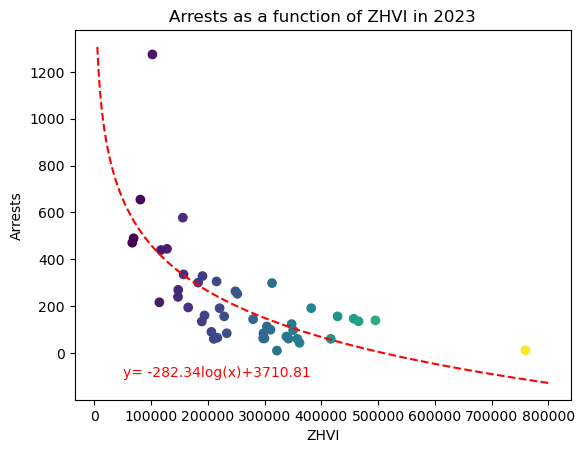

In [17]:
np.polyfit(np.log(newlist[6]['ZHVI']), newlist[6]['offense_count'], 1)
x = np.linspace(5000,800000,100000)
y= -282.33888733*np.log(x)+3710.81488274

plt.scatter(newlist[6]['ZHVI'],newlist[6]['offense_count'],c=newlist[6]['ZHVI'],)
plt.plot(x,y,color = 'red',linestyle='--')
plt.title('Arrests as a function of ZHVI in 2023')
plt.text(50000,-100,'y= -282.34log(x)+3710.81',color='red')
plt.xlabel('ZHVI')
plt.ylabel('Arrests')
plt.savefig('Results/arrests_vs_zhvi_2023')
plt.show()